In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=8d9a73504dd9580e6cc99a53ceba5ac3dbc0fb50b1f2a1558ab113f57c9bef36
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models


In [3]:
# Important imports
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
import seaborn as sns


In [4]:
# Parameters
SEQ_LEN = 20
BATCH_SIZE = 4
IM_SIZE = 112
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor()
])

Defining the model and dataset.

In [5]:
# Model
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        base_model = models.resnext50_32x4d(weights=None)
        self.cnn = nn.Sequential(*list(base_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.dp = nn.Dropout(0.4)
        self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, seq_len, c, h, w = x.shape
        x = x.view(b * seq_len, c, h, w)
        fmap = self.cnn(x)
        x = self.avgpool(fmap)
        x = x.view(b, seq_len, 2048)
        x_lstm, _ = self.lstm(x)
        x = torch.mean(x_lstm, dim=1)
        return fmap, self.dp(self.linear(x))

# Dataset
class video_dataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=20, transform=None):
        self.video_names = [v for v in video_names if os.path.exists(v)]
        self.labels = labels
        self.count = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        temp_video = os.path.basename(video_path)
        label = self.labels.loc[self.labels["file"] == temp_video, "label"].values[0]

        for frame in self.frame_extract(video_path):
            if frame is None:
                continue
            frames.append(self.transform(frame))
            if len(frames) == self.count:
                break

        if len(frames) == 0:
            return self.__getitem__((idx + 1) % len(self.video_names))

        frames = torch.stack(frames)
        if frames.shape[0] < self.count:
            pad_count = self.count - frames.shape[0]
            last_frame = frames[-1].unsqueeze(0).repeat(pad_count, 1, 1, 1)
            frames = torch.cat([frames, last_frame], dim=0)

        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = True
        while success:
            success, image = vidObj.read()
            if success:
                yield image


In [6]:
# Utilities
def read_list(txt_path):
    with open(txt_path, 'r') as f:
        files = [line.strip() for line in f.readlines()]
    return [f for f in files if os.path.exists(f)]

def assign_label(path):
    path_low = path.lower()
    return 1 if any(x in path_low for x in ["fake", "deepfake", "manipulated"]) else 0

def get_predictions(model, loader, device):
    model.eval()
    preds, probs, targets = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            _, outputs = model(inputs)
            p = torch.argmax(outputs, dim=1)
            prob = torch.softmax(outputs, dim=1)[:, 1]
            preds.extend(p.cpu().numpy())
            probs.extend(prob.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return preds, probs, targets

def plot_roc(probs, targets, title):
    fpr, tpr, _ = roc_curve(targets, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion(preds, targets, title):
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()


Testing for the accuracy, ROC curve, f1 score and Confusion Matrix.

Baseline Model on Baseline Test Set -- Accuracy: 68.50%, F1 Score: 0.67


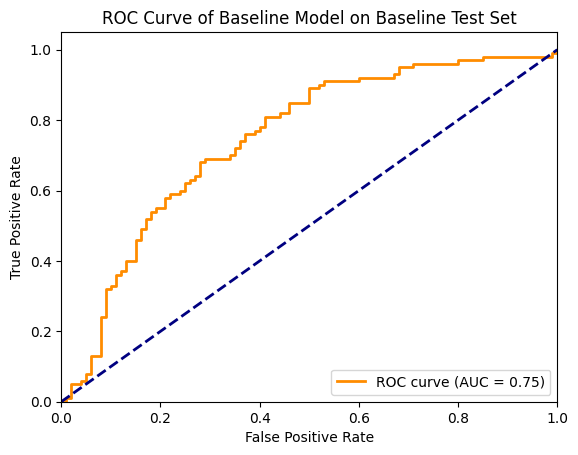

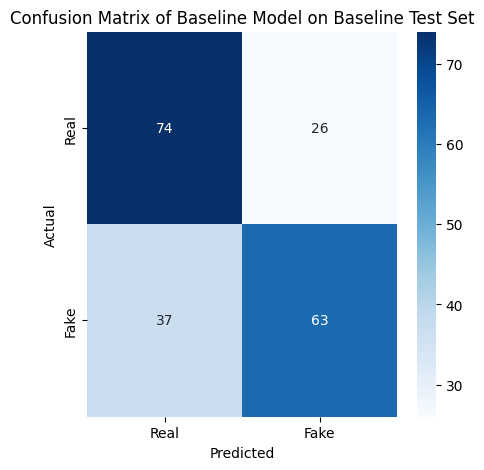

Baseline Model on Adversarial Test Set -- Accuracy: 65.00%, F1 Score: 0.58


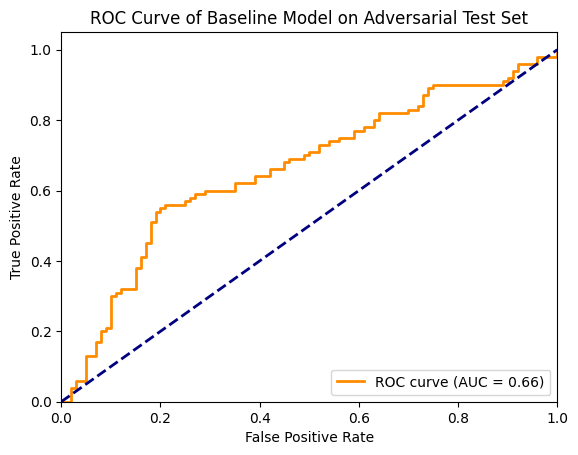

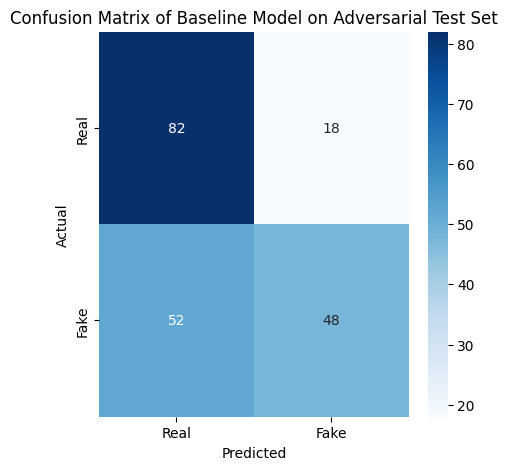

Fine-tuned Model on Baseline Test Set -- Accuracy: 70.50%, F1 Score: 0.69


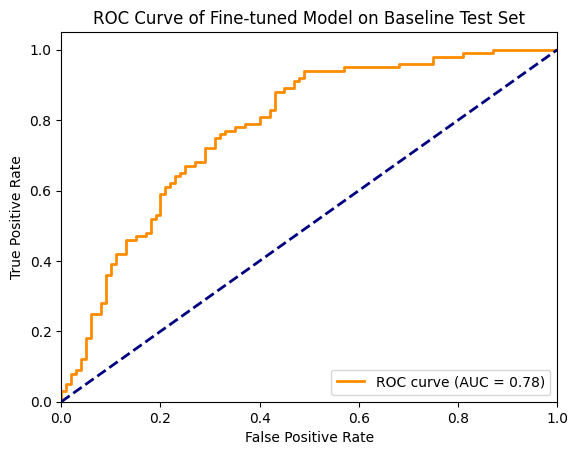

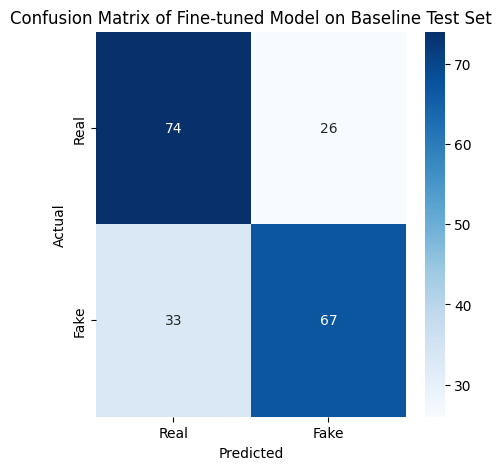

Fine-tuned Model on Adversarial Test Set -- Accuracy: 67.00%, F1 Score: 0.58


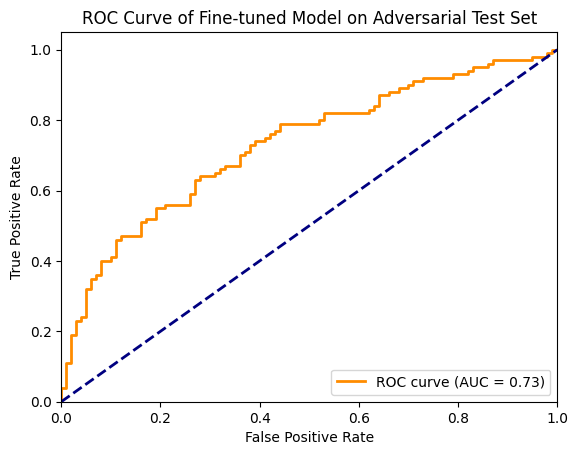

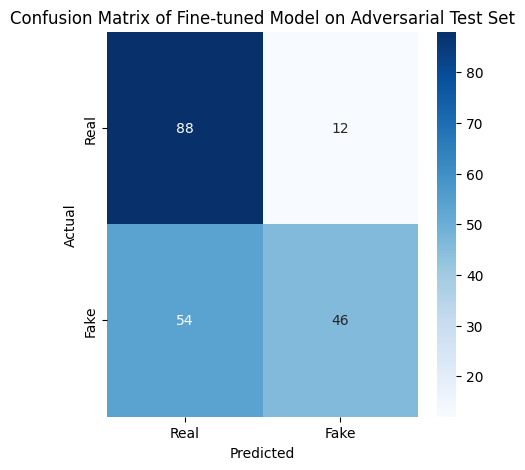

In [ ]:
# Test sets
baseline_test_txt = "../Dataset_split/baseline_splits/test.txt"
adversarial_test_txt = "../Dataset_split/adversarial_splits/test.txt"

baseline_test_files = read_list(baseline_test_txt)
adversarial_test_files = read_list(adversarial_test_txt)

baseline_test_labels = pd.DataFrame({
    "file": [os.path.basename(f) for f in baseline_test_files],
    "label": [assign_label(f) for f in baseline_test_files]
})
adversarial_test_labels = pd.DataFrame({
    "file": [os.path.basename(f) for f in adversarial_test_files],
    "label": [assign_label(f) for f in adversarial_test_files]
})

baseline_loader = DataLoader(video_dataset(baseline_test_files, baseline_test_labels, SEQ_LEN, transform=val_transform),
                             batch_size=BATCH_SIZE, shuffle=False)
adversarial_loader = DataLoader(video_dataset(adversarial_test_files, adversarial_test_labels, SEQ_LEN, transform=val_transform),
                                batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# Checkpoints
# -------------------------
baseline_ckpt = "../Baseline_model/models/model_epoch_38.pt"
finetune_ckpt = "../Fine-tuning/models/model_epoch_21.pt"

# -------------------------
# Evaluate models
# -------------------------
for model_name, ckpt_path in [("Baseline Model", baseline_ckpt), ("Fine-tuned Model", finetune_ckpt)]:
    model = Model(2).to(device)
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])

    for loader_name, loader in [("Baseline Test Set", baseline_loader), ("Adversarial Test Set", adversarial_loader)]:
        preds, probs, targets = get_predictions(model, loader, device)
        acc = 100 * sum([p==t for p,t in zip(preds,targets)]) / len(targets)
        f1 = f1_score(targets, preds)
        print(f"{model_name} on {loader_name} -- Accuracy: {acc:.2f}%, F1 Score: {f1:.2f}")
        plot_roc(probs, targets, f"ROC Curve of {model_name} on {loader_name}")
        plot_confusion(preds, targets, f"Confusion Matrix of {model_name} on {loader_name}")


In [7]:
# Additional Helper Functions
def calculate_accuracy(outputs, targets):
    _, pred = outputs.max(1)
    return pred.eq(targets).cpu().numpy(), pred.cpu().numpy(), targets.cpu().numpy()

def get_model_predictions(model, data_loader, device):
    model.eval()
    all_correct = []
    all_pred = []
    all_true = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.long().to(device)
            _, outputs = model(inputs)
            correct, pred, true = calculate_accuracy(outputs, targets)
            all_correct.extend(correct)
            all_pred.extend(pred)
            all_true.extend(true)
    return all_correct, all_pred, all_true

In [ ]:
# Load Adversarial Test Set
test_txt = "../Dataset_split/adversarial_splits/test.txt"
with open(test_txt, "r") as f:
    test_files = [line.strip() for line in f.readlines() if os.path.exists(line.strip())]

# Filter files that are truly from adversarial folders
adv_files = [f for f in test_files if "adversarial" in f.lower()]

# Create labels dataframe
adv_labels = pd.DataFrame({
    "file": [os.path.basename(p) for p in adv_files],
    "label": [assign_label(p) for p in adv_files]
})

test_dataset = video_dataset(adv_files, adv_labels, SEQ_LEN, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Checkpoints
baseline_ckpt = "../Baseline_model/models/model_epoch_38.pt"
adv_ckpt = "../Fine-tuning/models/model_epoch_21.pt"

for name, ckpt_path in [("Baseline Model", baseline_ckpt), ("Adversarial Fine-tuned Model", adv_ckpt)]:
    model = Model(2).to(device)
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])

    correct, pred, true = get_model_predictions(model, test_loader, device)
    total = len(true)
    correct_count = sum(correct)
    incorrect_count = total - correct_count
    print(f"\n--- {name} on Adversarial Test Set ---")
    print(f"Total videos: {total}")
    print(f"Correctly predicted: {correct_count}")
    print(f"Incorrectly predicted: {incorrect_count}")


--- Baseline Model on Adversarial Test Set ---
Total videos: 50
Correctly predicted: 25
Incorrectly predicted: 25

--- Adversarial Fine-tuned Model on Adversarial Test Set ---
Total videos: 50
Correctly predicted: 22
Incorrectly predicted: 28
